In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import copy

C:\Users\peter\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#RANGE = 12

In [4]:
def create_facility(toSelect: str) -> [[float]]:
    df = pd.read_csv("kosice_radius.csv")
    
    df = df[df["aminity"] == toSelect]

    
    df['lat'] = df['lat'].astype(float)
    df['lon'] = df['lon'].astype(float)
    df['lat_calc'] = df['lat'] - df['lat'].min()
    df['lon_calc'] = df['lon'] - df['lon'].min()

    df['lon_calc'] = df['lon_calc'].apply(lambda x : round(x,8))
    df['lat_calc'] = df['lat_calc'].apply(lambda x : round(x,8))

    df['lon_calc'] = df['lon_calc'] * 1000
    df['lat_calc'] = df['lat_calc'] * 1000
    
    #rows, cols = int(df['lon_calc'].max()), int(df['lat_calc'].max())
    rows, cols = 91, 52
    print(f"rows - {rows}, cols- {cols}")

    # create a (5,5) array of zeros
    arr = np.zeros((cols,rows))

    latMax = int(df['lat_calc'].max())
    lonMax = int(df['lon_calc'].max())
    for index, row in df.iterrows():
        lat = int(row['lat_calc']) - 1
        lon = int(row['lon_calc']) - 1
        for i in range(max(0, lon - RANGE), min(lonMax-1, lon + RANGE)):
            for j in range(max(0, lat - RANGE), min(latMax-1, lat + RANGE)):
                arr[j][i] += 0.5
        arr[lat-1][lon-1] = 1
    arr = np.flipud(arr)
    return arr, df

In [5]:
class FitnessFunction:
    def __init__(self, pop):
        self.reward = 0.5
        self.pop = pop
        self.fitnessValues = list() 
            
    def fitness_function(self):
        for city in self.pop.population:
            self.fitnessValues.append(np.sum(city))
        self.insertion_sort()
    
    def insertion_sort(self) -> None:
        for i in range(1, len(self.fitnessValues)):
     
            keyFitness = copy.deepcopy(self.fitnessValues[i])
            keyPopulation = copy.deepcopy(self.pop.population[i])
            j = i-1
            
            while j >= 0 and keyFitness > self.fitnessValues[j]:
                self.fitnessValues[j + 1] = self.fitnessValues[j]
                self.pop.population[j + 1] = self.pop.population[j]
                j -= 1
                
            self.fitnessValues[j + 1] = keyFitness
            self.pop.population[j + 1] = keyPopulation
        
    def resetEssentials(self) -> None:
        self.fitnessValues = list()
        self.pop.population = list()

In [70]:
class Mutation:
    def __init__(self, ff: object, initPop: object, numFacilities: int):
        self.ff = ff
        self.pop = initPop
        self.mutation_rate = 0.1
        self.crossover_rate = 0.5
        self.numBest = 5
        self.tries = numFacilities
        
    def findDifferentValue(self) -> [int]:
        probList = list()
        for i in range(self.numBest):
            p = 1 - self.ff.fitnessValues[i]/sum(self.ff.fitnessValues[:self.numBest])
            probList.append(p)
        return probList
        
    def pickBest(self) -> None:
        self.bestIndividuals = list()
        ps = self.findDifferentValue()
        
        for _ in range(self.numBest):
            randomNum = random.random()
            counter = 0
            for i in range(len(ps)):
                counter += ps[i]
                if counter > randomNum:
                    self.bestIndividuals.append(copy.deepcopy(self.pop.population[i]))
                    break

    def randomPicker(self) -> [int]:
        randomPickedPop = list()
        
        for i in range(self.pop.population_size - (self.numBest * 2)):
            idx = random.randint(0, self.pop.population_size-1)
            randomPickedPop.append(copy.deepcopy(self.pop.population[idx]))
        return randomPickedPop
    
    def checkFacility(self, chromosome):
        reward = 2
        for gen in chromosome:
            if gen > 15 and gen >= 1:
                reward -= 0.015
        return round(reward,2)
    
    def mutationClassic(self, chromosome: [int]) -> [int]:
        for num in range(self.tries):
            i = random.randint(RANGE, len(chromosome)-RANGE)
            j = random.randint(RANGE, len(chromosome[i])-RANGE)
            for k in range(RANGE):
                chromosome[i-k][j-RANGE:j+RANGE] += self.checkFacility(chromosome[i-k][j-RANGE:j+RANGE])

            for k in range(1,RANGE):
                chromosome[i+k][j-RANGE:j+RANGE] += self.checkFacility(chromosome[i+k][j-RANGE:j+RANGE])

        return chromosome

    def selection(self, randomPickedPop: [int]) -> None:
        self.ff.resetEssentials()
        numbers = [i for i in range(len(randomPickedPop))]
        
        for i in range(0,len(randomPickedPop)):        
            if random.random() <= self.mutation_rate:
                randomPickedPop[i] = self.mutationClassic(randomPickedPop[i])
            
            self.pop.population.append(copy.deepcopy(randomPickedPop[i]))
        

        for i in range(len(self.bestIndividuals)):
            self.pop.population.append(copy.deepcopy(self.bestIndividuals[i]))

        self.ff.fitness_function()
        
    def mainLoop(self) -> None:
        self.pickBest()
        randomPickedPop = self.randomPicker()
        
        for i in range(len(self.bestIndividuals)):
            randomPickedPop.append(copy.deepcopy(self.bestIndividuals[i]))
            
        random.shuffle(randomPickedPop)
        self.selection(randomPickedPop)

class Population:
    def __init__(self):
        self.population = list()
        self.population_size = 1000
        
    def generate_population(self, city):
        for i in range(self.population_size):
            self.population.append(copy.deepcopy(city))

In [71]:
def request_func(toSelect: str, numFacilities: int, radius: int):
    global RANGE
    RANGE = radius
    arr, selected_df = create_facility(toSelect)
    
    pop = Population()
    pop.generate_population(arr)

    ff = FitnessFunction(pop)
    ff.fitness_function()
    print(ff.fitnessValues[:5])

    mut = Mutation(ff, pop, numFacilities)
    mut.mainLoop()
    print(ff.fitnessValues[:5])
    
    arr2 = copy.deepcopy(pop.population[0])
    return arr2, arr
    # replace the zeros with -1 using the mask

In [95]:
toSelect = "School"

arr1, arr = request_func(toSelect, 2, 11)

rows - 91, cols- 52
[23443.0, 23443.0, 23443.0, 23443.0, 23443.0]
[25291.0, 25291.0, 25291.0, 25291.0, 25291.0]


['Shop' 'School' 'Transport' 'Job' 'Sport' 'GreenPlace'
 'Special mediacal care' 'Hospital' 'Drug store' 'culture']
rows - 91, cols- 52


<AxesSubplot:>

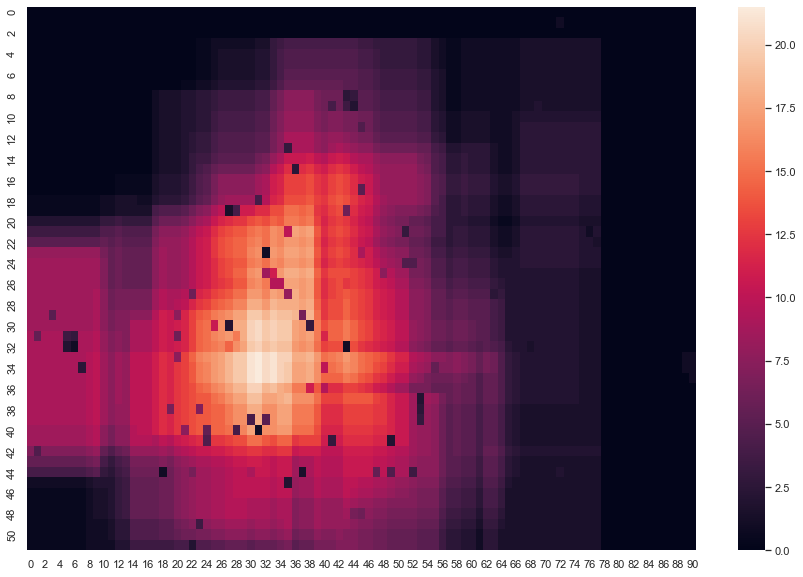

In [96]:
df = pd.read_csv("kosice_radius.csv")

print(df.aminity.unique())
df = df[df["aminity"] == toSelect]


df['lat'] = df['lat'].astype(float)
df['lon'] = df['lon'].astype(float)
df['lat_calc'] = df['lat'] - df['lat'].min()
df['lon_calc'] = df['lon'] - df['lon'].min()

df['lon_calc'] = df['lon_calc'].apply(lambda x : round(x,8))
df['lat_calc'] = df['lat_calc'].apply(lambda x : round(x,8))

df['lon_calc'] = df['lon_calc'] * 1000
df['lat_calc'] = df['lat_calc'] * 1000

#rows, cols = int(df['lon_calc'].max()), int(df['lat_calc'].max())
rows, cols = 91, 52
print(f"rows - {rows}, cols- {cols}")

# create a (5,5) array of zeros
arr = np.zeros((cols,rows))

latMax = int(df['lat_calc'].max())
lonMax = int(df['lon_calc'].max())
for index, row in df.iterrows():
    lat = int(row['lat_calc']) - 1
    lon = int(row['lon_calc']) - 1
    for i in range(max(0, lon - RANGE), min(lonMax-1, lon + RANGE)):
        for j in range(max(0, lat - RANGE), min(latMax-1, lat + RANGE)):
            arr[j][i] += 0.5
    arr[lat-1][lon-1] = 1
arr = np.flipud(arr)

sns.heatmap(arr)

<AxesSubplot:>

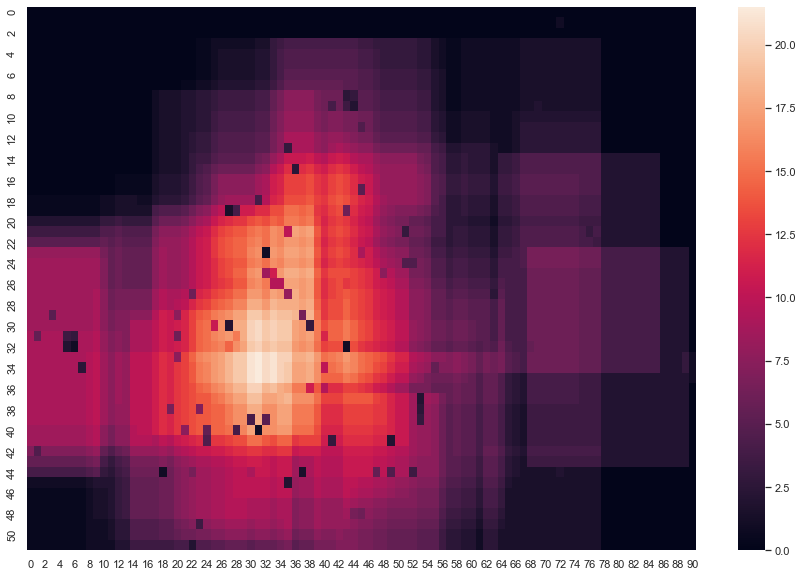

In [97]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(arr1)

In [40]:
df = pd.read_csv("kosice_radius.csv")

In [38]:
df.to_json("kosice_radius.json", orient="records")